## 梯度下降
尽管梯度下降（gradient descent）很少直接⽤于深度学习，但了解它是理解下⼀节随机梯度下降算法的
关键。例如，由于学习率过⼤，优化问题可能会发散，这种现象早已在梯度下降中出现。同样地，预处理
（preconditioning）是梯度下降中的⼀种常⽤技术，还被沿⽤到更⾼级的算法中。让我们从简单的⼀维梯度
下降开始。

### 一维梯度下降
为什么梯度下降算法可以优化⽬标函数？⼀维中的梯度下降给我们很好的启发。考虑⼀类连续可微实值函
数f : R → R，利⽤泰勒展开，我们可以得到

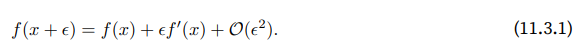

即在⼀阶近似中，f(x + ϵ)可通过x处的函数值f(x)和⼀阶导数f′(x)得出。我们可以假设在负梯度⽅向上移动
的ϵ会减少f。为了简单起⻅，我们选择固定步⻓η > 0，然后取ϵ = −ηf′(x)。将其代⼊泰勒展开式我们可以得到

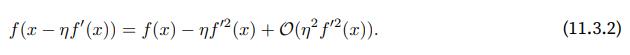

如果其导数f′(x) ̸= 0没有消失，我们就能继续展开，这是因为ηf′2
(x) > 0。此外，我们总是可以令η⼩到⾜以使⾼阶项变得不相关。因此，

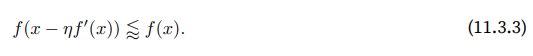

这意味着，如果我们使⽤  
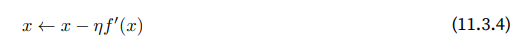

来迭代x，函数f(x)的值可能会下降。因此，在梯度下降中，我们⾸先选择初始值x和常数η > 0，然后使⽤它
们连续迭代x，直到停⽌条件达成。例如，当梯度|f′(x)|的幅度⾜够⼩或迭代次数达到某个值时。
下⾯我们来展⽰如何实现梯度下降。为了简单起⻅，我们选⽤⽬标函数f(x) = x
2。尽管我们知道x = 0时f(x)能
取得最⼩值，但我们仍然使⽤这个简单的函数来观察x的变化。


In [2]:

import numpy as np
import torch
from d2l import torch as d2l

def f(x): # ⽬标函数
    return x ** 2

def f_grad(x): # ⽬标函数的梯度(导数)
    return 2 * x



接下来，我们使⽤x = 10作为初始值，并假设η = 0.2。使⽤梯度下降法迭代x共10次，我们可以看到，x的值
最终将接近最优解。


In [3]:
def gd(eta, f_grad):
    x = 10.0

    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results


results = gd(0.2, f_grad)

epoch 10, x: 0.060466


对进⾏x优化的过程可以绘制如下。

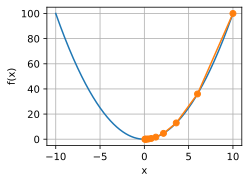

In [4]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

show_trace(results, f)


#### 学习率
学习率（learning rate）决定⽬标函数能否收敛到局部最⼩值，以及何时收敛到最⼩值。学习率η可由算法设
计者设置。请注意，如果我们使⽤的学习率太⼩，将导致x的更新⾮常缓慢，需要更多的迭代。例如，考虑同
⼀优化问题中η = 0.05的进度。如下所⽰，尽管经过了10个步骤，我们仍然离最优解很远。

epoch 10, x: 3.486784


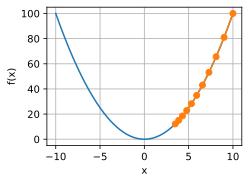

In [5]:
show_trace(gd(0.05, f_grad), f)


相反，如果我们使⽤过⾼的学习率，|ηf′(x)|对于⼀阶泰勒展开式可能太⼤。也就是说，(11.3.1)中
的O(η2f′2(x))可能变得显著了。在这种情况下，x的迭代不能保证降低f(x)的值。例如，当学习率为η = 1.1时，
x超出了最优解x = 0并逐渐发散。


epoch 10, x: 61.917364


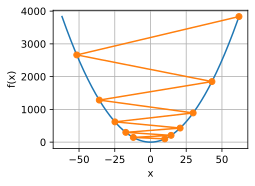

In [6]:
show_trace(gd(1.1, f_grad), f)

#### 局部最小值
为了演⽰⾮凸函数的梯度下降，考虑函数f(x) = x · cos(cx)，其中c为某常数。这个函数有⽆穷多个局部最⼩
值。根据我们选择的学习率，我们最终可能只会得到许多解的⼀个。下⾯的例⼦说明了（不切实际的）⾼学
习率如何导致较差的局部最⼩值。

常数： tensor(0.4712)
epoch 10, x: -1.528166


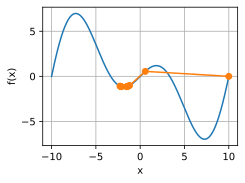

In [8]:
c = torch.tensor(0.15 * np.pi)
print("常数：",c)

def f(x): # ⽬标函数
    return x * torch.cos(c * x)

def f_grad(x): # ⽬标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

### 多元梯度下降
现在我们对单变量的情况有了更好的理解，让我们考虑⼀下x = [x1, x2, . . . , xd]
⊤的情况。即⽬标函数f : Rd →R将向量映射成标量。相应地，它的梯度也是多元的，它是⼀个由d个偏导数组成的向量：

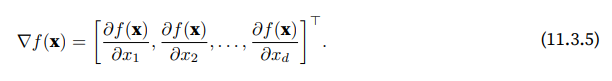

梯度中的每个偏导数元素∂f(x)/∂xi代表了当输⼊xi时f在x处的变化率。和先前单变量的情况⼀样，我们可
以对多变量函数使⽤相应的泰勒近似来思考。具体来说，

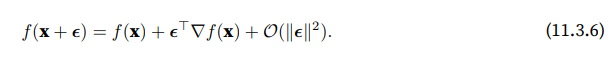

换句话说，在ϵ的⼆阶项中，最陡下降的⽅向由负梯度−∇f(x)得出。选择合适的学习率η > 0来⽣成典型的梯
度下降算法：

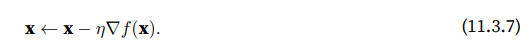

这个算法在实践中的表现如何呢？我们构造⼀个⽬标函数f(x) = x21 + 2x22，并有⼆维向量x = [x1, x2]
⊤作为输⼊，标量作为输出。梯度由∇f(x) = [2x1, 4x2]⊤给出。我们将从初始位置[−5, −2]通过梯度下降观察x的轨
迹。

我们还需要两个辅助函数：第⼀个是update函数，并将其应⽤于初始值20次；第⼆个函数会显⽰x的轨迹。


In [9]:
def train_2d(trainer, steps=20, f_grad=None): #@save
    """⽤定制的训练机优化2D⽬标函数"""
    # s1和s2是稍后将使⽤的内部状态变量
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results): #@save
    """显⽰优化过程中2D变量的轨迹"""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
    torch.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')


接下来，我们观察学习率η = 0.1时优化变量x的轨迹。可以看到，经过20步之后，x的值接近其位于[0, 0]的最
⼩值。虽然进展相当顺利，但相当缓慢。


epoch 20, x1: -0.057646, x2: -0.000073


d:\anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


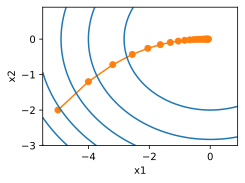

In [10]:
def f_2d(x1, x2): # ⽬标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2): # ⽬标函数的梯度
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))


### 自适应方法
正如我们在 11.3.1节中所看到的，选择“恰到好处”的学习率η是很棘⼿的。如果我们把它选得太⼩，就没有
什么进展；如果太⼤，得到的解就会振荡，甚⾄可能发散。如果我们可以⾃动确定η，或者完全不必选择学习
率，会怎么样？除了考虑⽬标函数的值和梯度、还考虑它的曲率的⼆阶⽅法可以帮我们解决这个问题。虽然
由于计算代价的原因，这些⽅法不能直接应⽤于深度学习，但它们为如何设计⾼级优化算法提供了有⽤的思
维直觉，这些算法可以模拟下⾯概述的算法的许多理想特性。

#### 【牛顿法】
回顾⼀些函数f : Rd → R的泰勒展开式，事实上我们可以把它写成

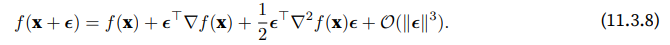

为了避免繁琐的符号，我们将Hdef = ∇2f(x)定义为f的Hessian，是d × d矩阵。当d的值很⼩且问题很简单时，
H很容易计算。但是对于深度神经⽹络⽽⾔，考虑到H可能⾮常⼤，O(d2)个条⽬的存储代价会很⾼，此外通
过反向传播进⾏计算可能雪上加霜。然⽽，我们姑且先忽略这些考量，看看会得到什么算法。

毕竟，f的最⼩值满⾜∇f = 0。遵循 2.4节中的微积分规则，通过取ϵ对 (11.3.8)的导数，再忽略不重要的⾼阶
项，我们便得到

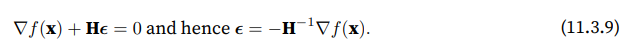

也就是说，作为优化问题的⼀部分，我们需要将Hessian矩阵H求逆。

举⼀个简单的例⼦，对于f(x) = 1
2
x
2，我们有∇f(x) = x和H = 1。因此，对于任何x，我们可以获得ϵ = −x。
换⾔之，单单⼀步就⾜以完美地收敛，⽽⽆须任何调整。我们在这⾥⽐较幸运：泰勒展开式是确切的，因
为f(x + ϵ) = 1
2
x
2 + ϵx +
1
2
ϵ
2。

看看其他问题。给定⼀个凸双曲余弦函数c，其中c为某些常数，我们可以看到经过⼏次迭代后，得到
了x = 0处的全局最⼩值。




epoch 10, x: tensor(0.)


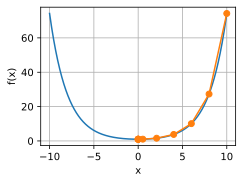

In [11]:
c = torch.tensor(0.5)
def f(x): # O⽬标函数
    return torch.cosh(c * x)

def f_grad(x): # ⽬标函数的梯度
    return c * torch.sinh(c * x)

def f_hess(x): # ⽬标函数的Hessian
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results
show_trace(newton(), f)


现在让我们考虑⼀个⾮凸函数，⽐如f(x) = x cos(cx)，c为某些常数。请注意在⽜顿法中，我们最终将除
以Hessian。这意味着如果⼆阶导数是负的，f的值可能会趋于增加。这是这个算法的致命缺陷！让我们看看
实践中会发⽣什么。


epoch 10, x: tensor(26.8341)


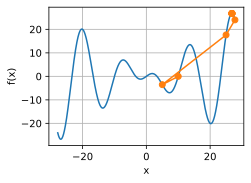

In [12]:
c = torch.tensor(0.15 * np.pi)
def f(x): # ⽬标函数
    return x * torch.cos(c * x)

def f_grad(x): # ⽬标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x): # ⽬标函数的Hessian
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)


这发⽣了惊⼈的错误。我们怎样才能修正它？⼀种⽅法是⽤取Hessian的绝对值来修正，另⼀个策略是重新
引⼊学习率。这似乎违背了初衷，但不完全是——拥有⼆阶信息可以使我们在曲率较⼤时保持谨慎，⽽在⽬
标函数较平坦时则采⽤较⼤的学习率。让我们看看在学习率稍⼩的情况下它是如何⽣效的，⽐如η = 0.5。如
我们所⻅，我们有了⼀个相当⾼效的算法。


epoch 10, x: tensor(7.2699)


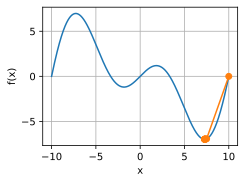

In [13]:
show_trace(newton(0.5), f)

## 小结
* 学习率的⼤⼩很重要：学习率太⼤会使模型发散，学习率太⼩会没有进展。
* 梯度下降会可能陷⼊局部极⼩值，⽽得不到全局最⼩值。
* 在⾼维模型中，调整学习率是很复杂的。
* 预处理有助于调节⽐例。
* ⽜顿法在凸问题中⼀旦开始正常⼯作，速度就会快得多。
* 对于⾮凸问题，不要不作任何调整就使⽤⽜顿法。

